# **Gravitational Wave Analysis** Part 3
## SHUBHAM 2K19/EP/093
In this notebook, I'll cover some different ways of representing data, including


1.   the spectrogram
2.   the Q-transfrom
---
## Install the required module(s)
This command is to be executed only when using Google Colab.


In [ ]:
! pip install -q 'gwpy==1.0.1'

     |████████████████████████████████| 1.4 MB 4.4 MB/s 
     |████████████████████████████████| 51 kB 7.2 MB/s 
     |████████████████████████████████| 55 kB 4.2 MB/s 
     |████████████████████████████████| 3.6 MB 30.1 MB/s 


---
## Import modules
---
Import modules and query for the data

In [ ]:
import numpy as np
from gwosc import datasets as gd
from gwpy import timeseries as gt, time as gm

In [ ]:
gps = gd.event_gps('GW170817')
segment = (int(gps)-512, int(gps)+512)
try:
    ldata = gt.TimeSeries.fetch_open_data('L1', *segment, cache=True)
    hdata = gt.TimeSeries.fetch_open_data('H1', *segment, cache=True)
except ValueError:
    print("Couldn't find")


In [ ]:
ldata

<TimeSeries([2.06056010e-20, 1.59181918e-20, 2.18438811e-20, ...,
             1.25504332e-19, 1.23976846e-19, 1.22231459e-19]
            unit=Unit(dimensionless),
            t0=<Quantity 1.18700837e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='Strain',
            channel=None)>

In [ ]:
hdata

<TimeSeries([5.73571971e-19, 5.79616885e-19, 5.76818759e-19, ...,
             4.70957633e-19, 4.58255672e-19, 4.61226401e-19]
            unit=Unit(dimensionless),
            t0=<Quantity 1.18700837e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='Strain',
            channel=None)>

---
## Showing the time-evolution of FFTs
---
The FFT, and the ASD, show us a snapshot of the frequency domain content of the signal, at a single time. It is commonly usefuk to show how this frequency-domain content evolves over time.\
For this, spectrograms are used, which show the FFT(or ASD) at each time step on a time-frequency-amplitude axis. The `TimeSeries` class in GWpy includes two methods for this:
* `spectrogram()` : shows an averaged ASD at each time step,
* `spectrogram2()` : shows a single-FFT ASD at each time step

Prefer to use:
1. `spectrogram2()` for short chunks of data, less than a minute time.
2. `spectrogram()` for longer chunks of data where the averaging helps remove very short noise bursts.

In [ ]:
lSpecGram = ldata.spectrogram2(fftlength=4, overlap=2, window="hann") ** (1/2.)
hSpecGram = hdata.spectrogram2(fftlength=4, overlap=2, window="hann") ** (1/2.)
np.shape(lSpecGram)

(512, 8193)

Plot the spectrogram

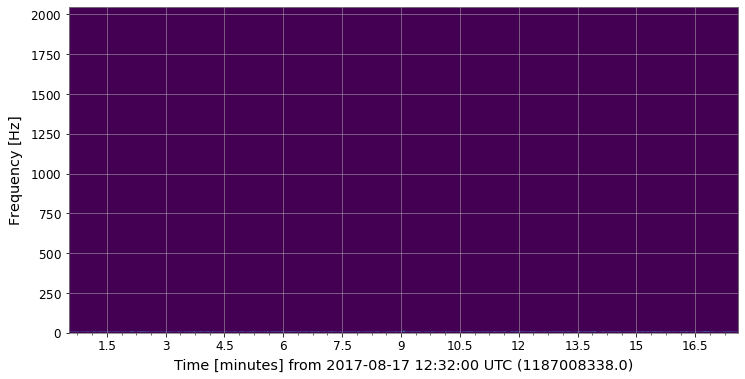

In [ ]:
lplot = lSpecGram.plot()

Data isn't visible yet, so, change the limits and scale of the axis

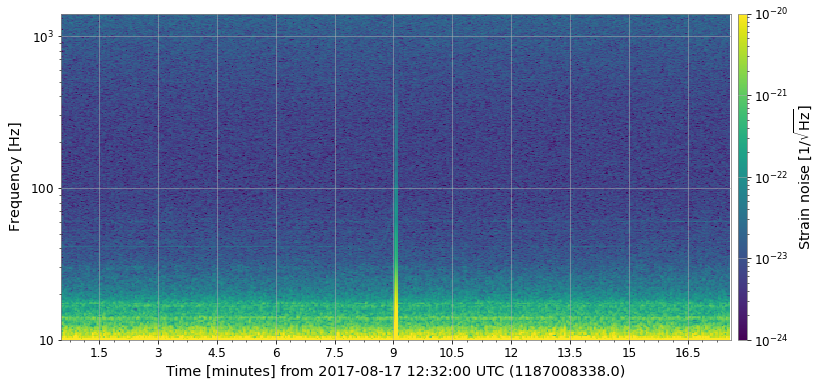

In [ ]:
lax = lplot.gca()
lax.set_yscale('log')
lax.set_ylim(10, 1400)
lax.colorbar(
    clim = (1e-24, 1e-20),
    norm = 'log',
    label = r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]"
)
lplot

Similarly, do it for Hanford data `hSpecGram`

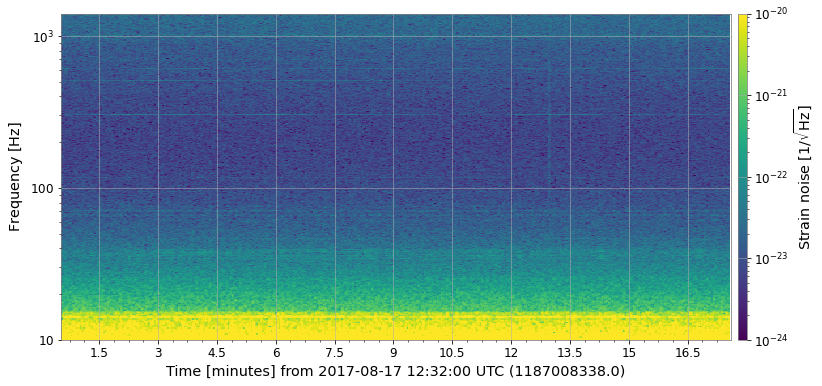

In [ ]:
hplot = hSpecGram.plot()
hax = hplot.gca()
hax.set_yscale('log')
hax.set_ylim(10, 1400)
hax.colorbar(
    clim = (1e-24, 1e-20),
    norm = 'log',
    label = r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]"
)

---
## Q-Transform in GWPY
---
The spectrogram above, is a useful way to show the variation of a power spectral density (PSD) estimate over time. It is best used to see general trends in how the sensitivity of the GW detectors is changing over long periods (minutes or hours).\
Since, I have already fetched the data of Hanford detector, so, I can now use the `q_transform()` method of the `hdata TimeSeries` to create our time-frequency representation (as a spectrogram).

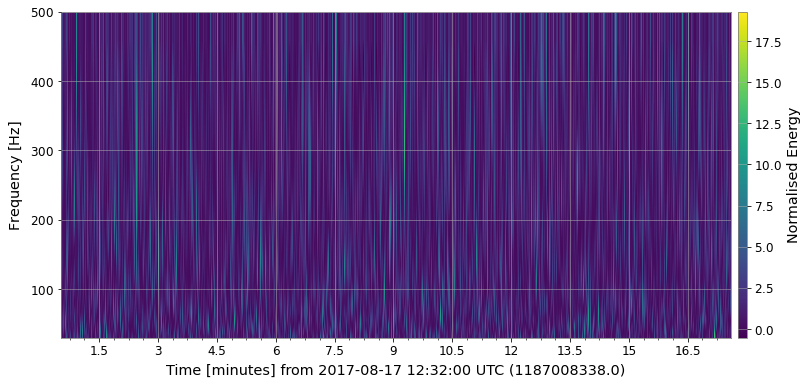

In [ ]:
hq = hdata.q_transform(frange=(30, 500))
hplot = hq.plot()
hplot.colorbar(label="Normalised Energy")

The above spectrogram contains a huge timedata, let's plot the spectrogram for comparitively less period.

In [ ]:
segment2 = (int(gps)-30, int(gps)+2)
try:
    hdata2 = gt.TimeSeries.fetch_open_data('H1', *segment2, verbose=True, cache=True)
    print(np.shape(hdata2))
except ValueError:
    print("Coudn't fetch")

Fetched 1 URLs from www.gw-openscience.org for [1187008852 .. 1187008884))
Reading data... [Done]
(131072,)


In [ ]:
hData2Q = hdata2.q_transform(frange=(30, 500))
np.shape(hData2Q)

(1000, 940)

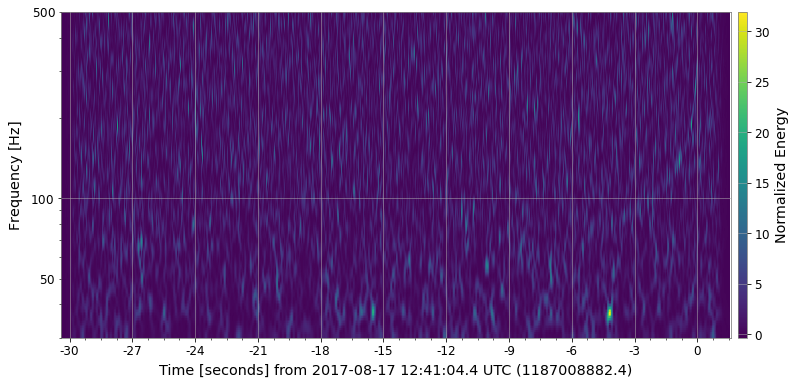

In [ ]:
hplot2q = hData2Q.plot()
h2qax = hplot2q.gca()
h2qax.set_epoch(gps)
h2qax.set_ylim(30, 500)
h2qax.set_yscale('log')
h2qax.colorbar(label="Normalized Energy")

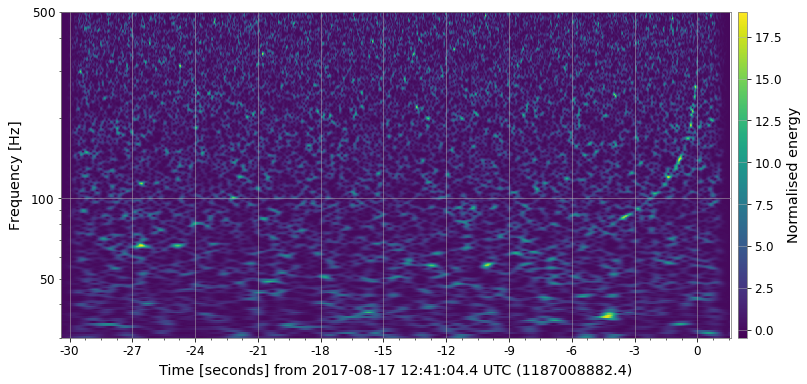

In [ ]:
h2q = hdata2.q_transform(frange=(30, 500), qrange=(100, 110))
h2qplot = h2q.plot()
hqax2 = h2qplot.gca()
hqax2.set_epoch(gps)
hqax2.set_yscale("log")
hqax2.colorbar(label = "Normalised energy")

Now, in the above plot, beautiful and clear track of a BNS merger can be seen, which is visible from about ~4 seconds, all the way through to the merger at T=0.
We shall now use `outseg` keyword argument option to zoom in around the merger.

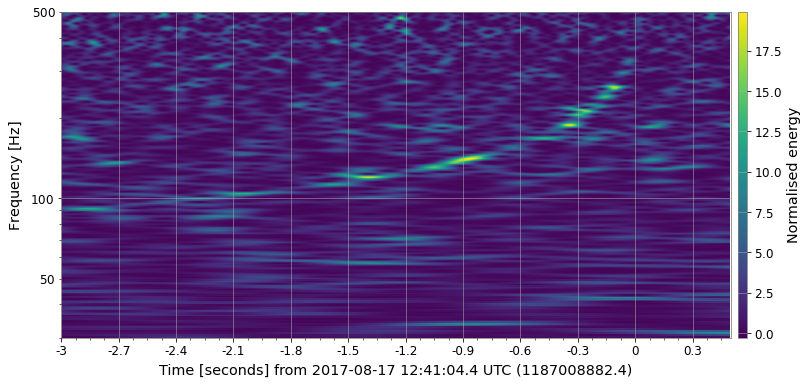

In [ ]:
hq2 = hdata2.q_transform(frange=(30, 500), qrange=(80, 110), outseg=(gps-3,gps+0.5))
hplot2 = hq2.plot()
haxq = hplot2.gca()
haxq.set_epoch(gps)
haxq.set_yscale('log')
haxq.colorbar(label="Normalised energy")                      

The above plots are of LIGO-Hanford data, one can also do the same for LIGO-Livingston

In [ ]:
# segment2 = (int(gps)-30, int(gps)+2)
try:
    ldata2 = gt.TimeSeries.fetch_open_data('L1', *segment2, verbose=True, cache=True)
    print(np.shape(ldata2))
except ValueError:
    print("Coudn't fetch")

Fetched 1 URLs from www.gw-openscience.org for [1187008852 .. 1187008884))
Reading data... [Done]
(131072,)


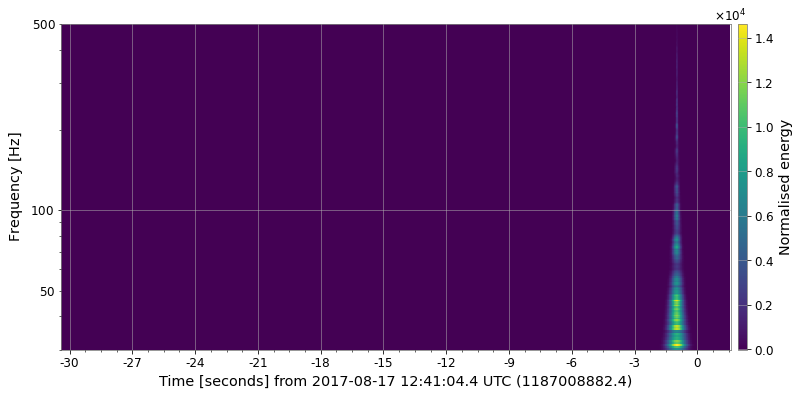

In [ ]:
l2q = ldata2.q_transform(frange=(30, 500), qrange=(100, 110))
l2plot = l2q.plot()
lax = l2plot.gca()
lax.set_epoch(gps)
lax.set_yscale('log')
lax.colorbar(label='Normalised energy')

A large blob of energy can be seen in the plot, which is 1000 times louder than what we see in the LIGO-Hanford data. An instrumental glitch almost exactly overlaps the BNS signal in LIGO-Livingston. But things can be rescaled in order to see the astrophysical signal better.

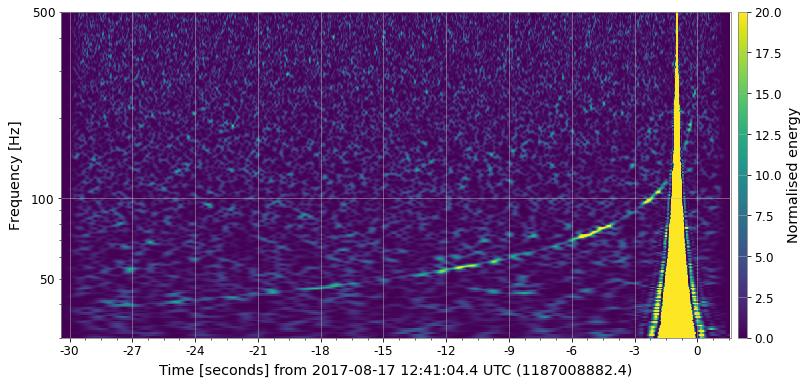

In [ ]:
l2plot.colorbars[0].mappable.set_clim(0, 20)
l2plot.refresh()
l2plot